# Advanced Lane Finding Project

The goals / steps of this project are the following:

### Camera calibration 
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

### Pipelines
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


---
# Camera calibration

In [304]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

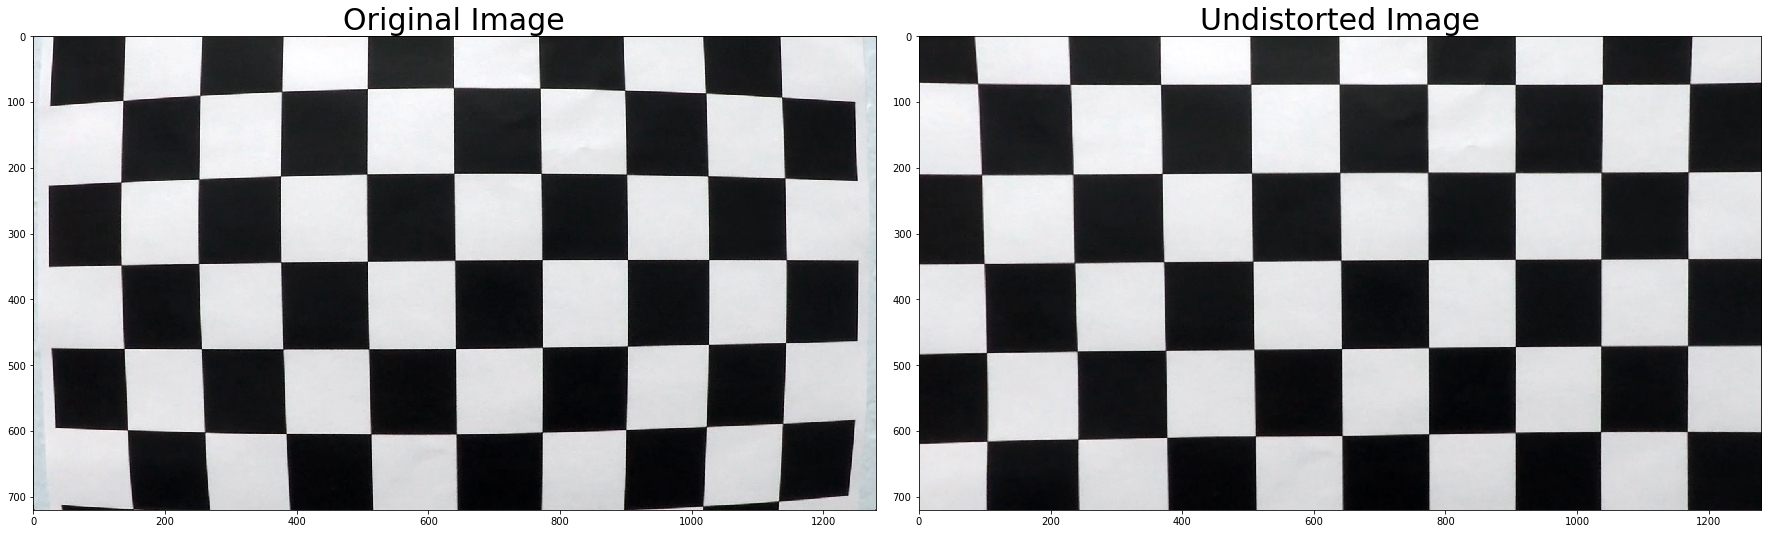

In [1841]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('output_images/calibration1_undist.jpg',f) 

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('../output_images/undistort_output.png')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)               

# Pipelines
## 1. Apply a distortion correction to raw images.

Text(0.5, 1.0, 'Undistorted Image')

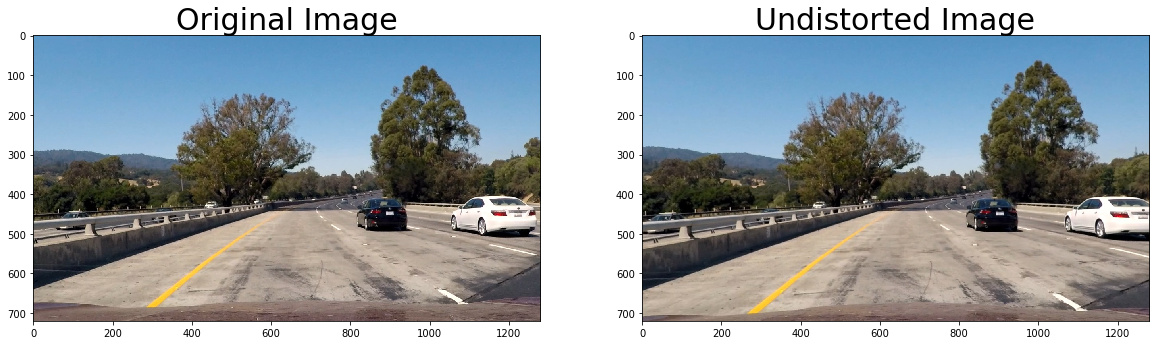

In [1168]:
"""
cv2.imread reads BGR, whereas mpimg.imread RGB
therefore, BGR2RGB is needed.
ipimg.imread reads RGB, which reqires no change.
In any case, r,g,b to b,g,r convert is needed to cv2.imwrite file.
ployt in disply requires no this convert since its in RGB.
"""
# img = cv2.imread('../test_images/test1.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = mpimg.imread('../test_images/test1.jpg')

undst = cv2.undistort(img, mtx, dist, None, mtx)

# Image file save.
r,g,b = cv2.split(undst)
result = cv2.merge((b,g,r))
cv2.imwrite('../output_images/test1_undistorted.jpg', result)

%matplotlib inline
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=30)

## 2. Use color transforms, gradients, etc., to create a thresholded binary image.

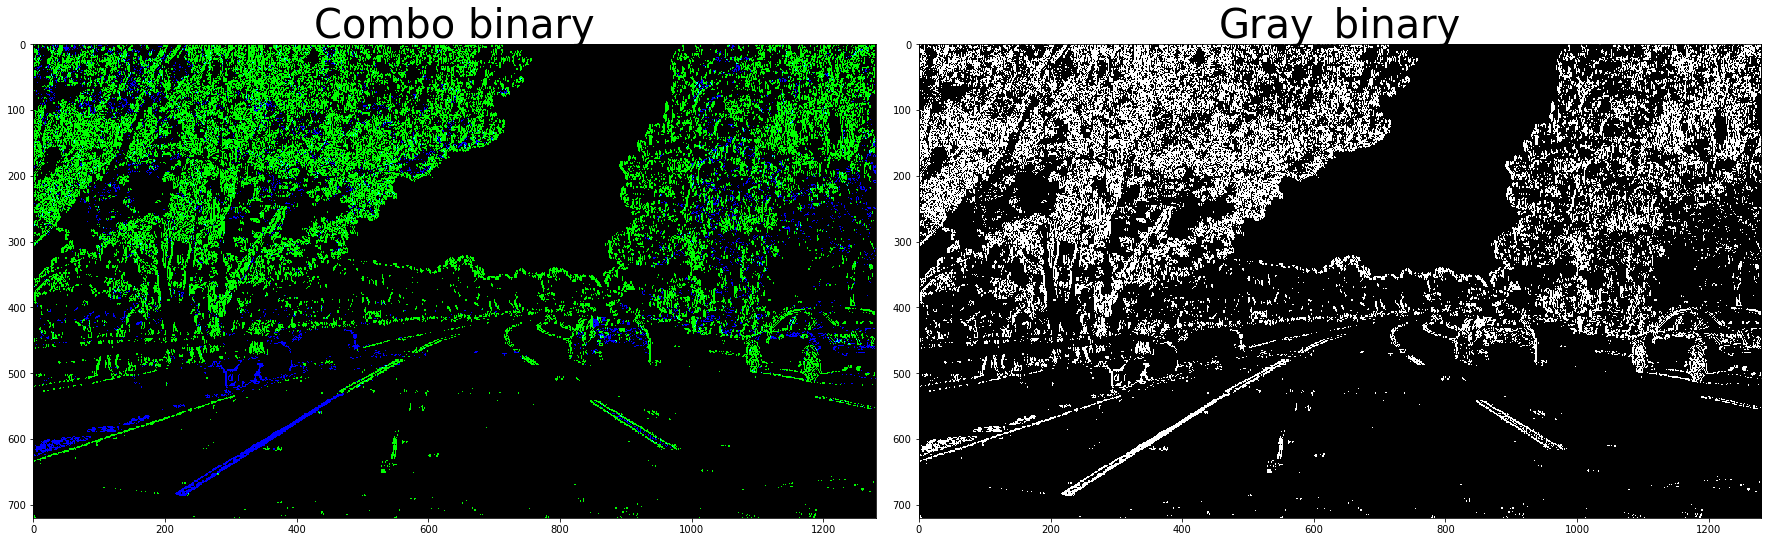

In [1567]:
image = mpimg.imread('../test_images/test5.jpg')
# image = mpimg.imread('../../bridge_shadow.jpg')
# Edit this function to create your own pipeline.
def create_binary_image(img, s_thresh=(170, 225), sx_thresh=(15, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    comb_binary = np.zeros_like(s_binary)
    comb_binary[(sxbinary == 1) | (s_binary == 1) ] = 1
    
    return color_binary, comb_binary
    
combo_binary, gray_binary = create_binary_image(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combo_binary,cmap='gray')
ax1.set_title('Combo binary', fontsize=40)

ax2.imshow(gray_binary,cmap='gray')
ax2.set_title('Gray_binary', fontsize=40)
plt.savefig('../output_images/thresholded_binary_images.png')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3. Apply a perspective transform to rectify binary image ("birds-eye view").

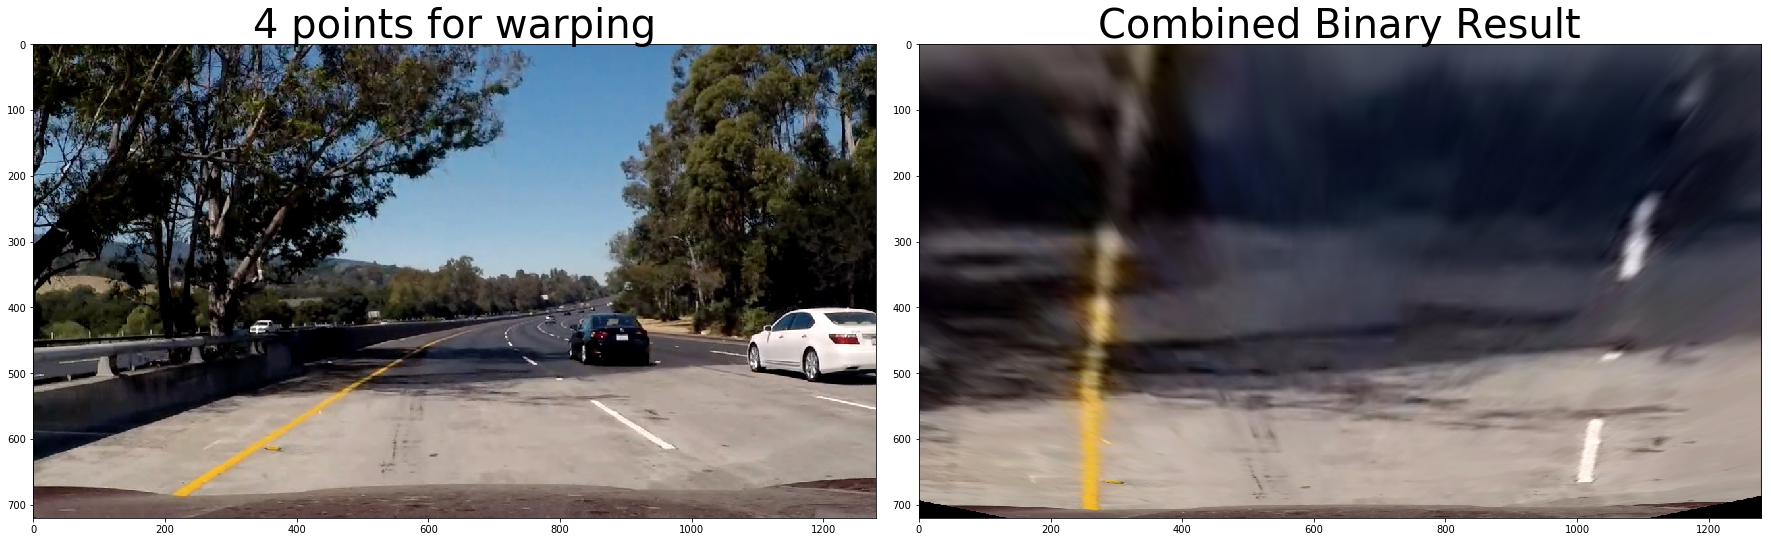

In [1765]:
image2 = mpimg.imread('../test_images/test5.jpg')

def get_birdeyeview(img):
    copied_image2 = np.copy(img)
    img_size2 = (copied_image2.shape[1], copied_image2.shape[0])

    # set 4 points for warping.
    src = np.float32(
       [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

    dst = np.float32(
       [[(img_size[0] / 4 - 30), 0],
        [(img_size[0] / 4 - 30), img_size[1]],
        [(img_size[0] * 3 / 4 + 30), img_size[1]],
        [(img_size[0] * 3 / 4 + 30), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst) #Transform function takes float32
    warped2 = cv2.warpPerspective(copied_image2, M, img_size, flags=cv2.INTER_LINEAR)

    return warped2

birdeye_view = get_birdeyeview(image2)

# plot the results onto subplots.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image2)
ax1.set_title('4 points for warping', fontsize=40)
ax2.imshow(birdeye_view)
ax2.set_title('Combined Binary Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

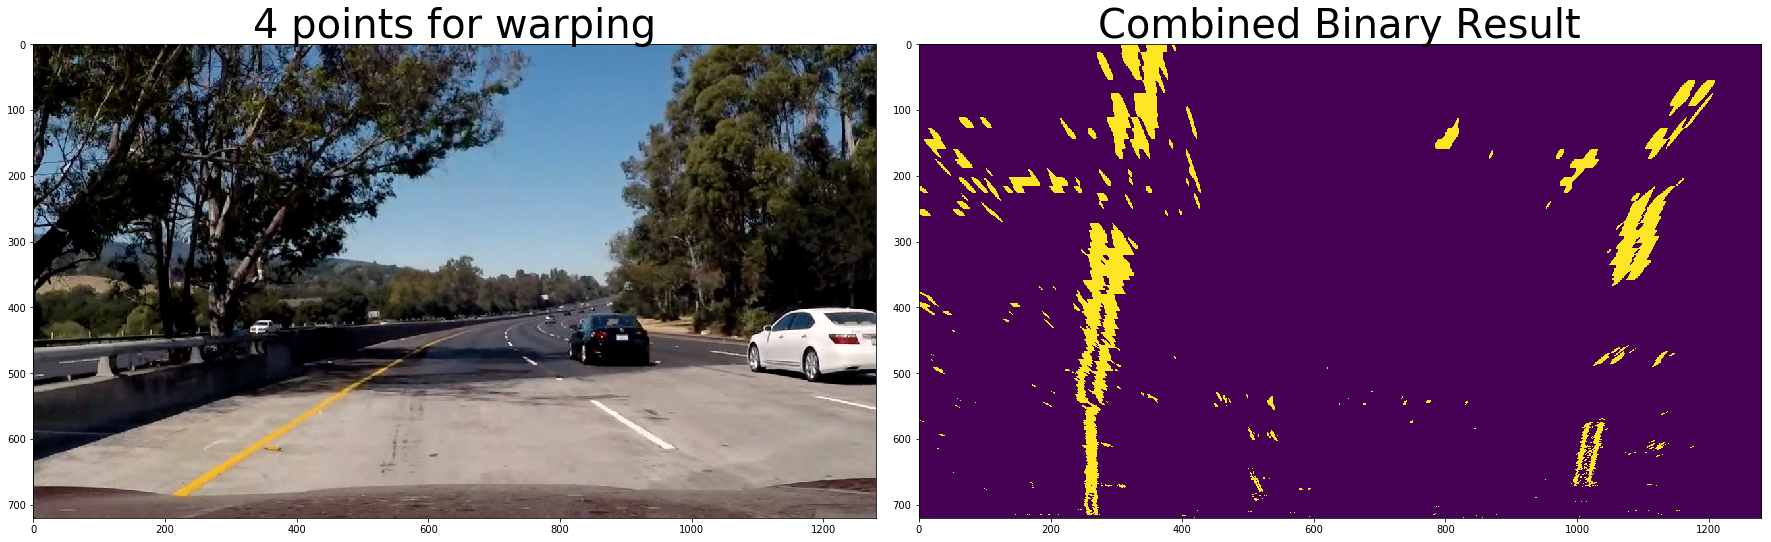

In [1836]:
image2 = mpimg.imread('../test_images/test5.jpg')

def get_birdeyeview(img):
    copied_image2 = np.copy(img)
    img_size2 = (copied_image2.shape[1], copied_image2.shape[0])
    copied_image2 = cv2.undistort(copied_image2, mtx, dist, None, mtx)

    # set 4 points for warping.
    src = np.float32(
       [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

    dst = np.float32(
       [[(img_size[0] / 4 - 30), 0],
        [(img_size[0] / 4 - 30), img_size[1]],
        [(img_size[0] * 3 / 4 + 30), img_size[1]],
        [(img_size[0] * 3 / 4 + 30), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst) #Transform function takes float32
    warped2 = cv2.warpPerspective(copied_image2, M, img_size, flags=cv2.INTER_LINEAR)

    return warped2

birdeye_view = get_birdeyeview(gray_binary)

# plot the results onto subplots.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image2)
ax1.set_title('4 points for warping', fontsize=40)
ax2.imshow(birdeye_view)
ax2.set_title('Combined Binary Result', fontsize=40)
plt.savefig('../output_images/create_birdeye_binary_image.jpg')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Detect lane pixels and fit to find the lane boundary.

267 1062


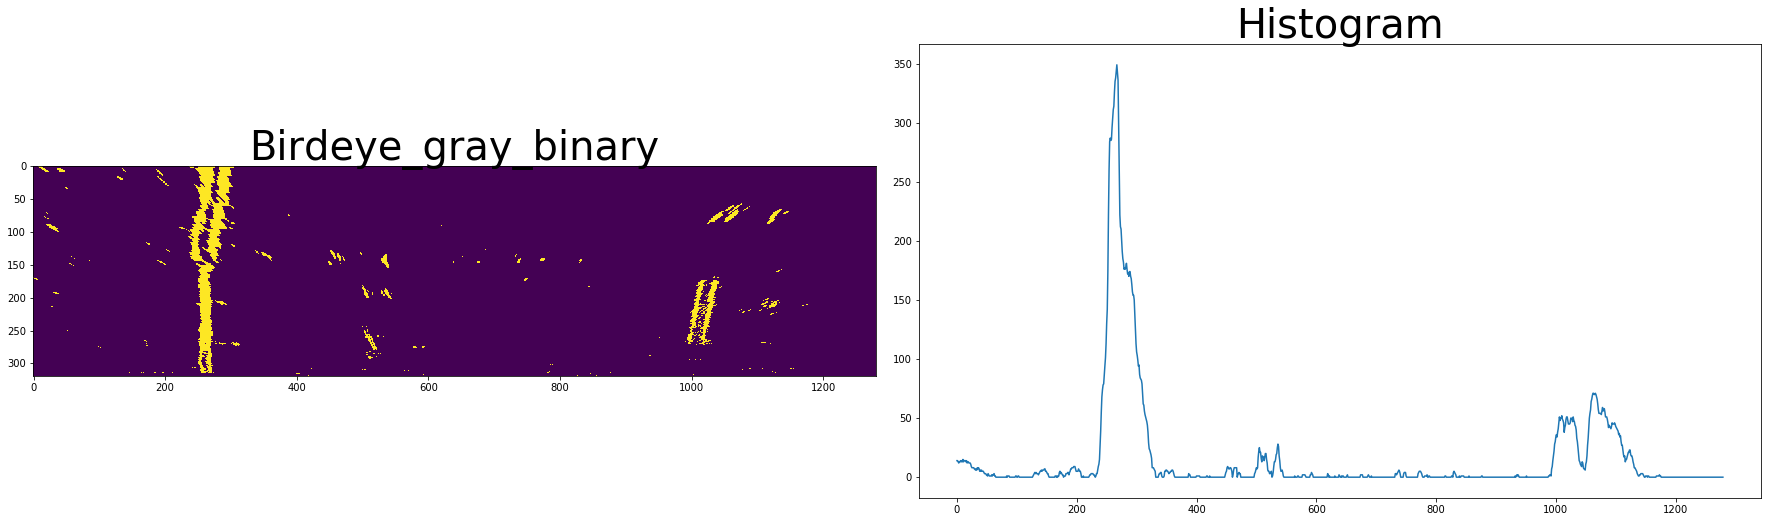

In [1768]:
def get_basex(img):
    histogram = np.sum(img[300:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

lx_base, rx_base = get_basex(birdeye_view)
print(lx_base, rx_base)
histogram = np.sum(birdeye_view[300:,:], axis=0)

# Visualize the resulting histogram
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 7))
f.tight_layout()
ax1.imshow(birdeye_view[400:,:])
# ax1.imshow(warped[warped.shape[0]//2:,:])
ax1.set_title('Birdeye_gray_binary', fontsize=40)
# ax2.imshow(result)
ax2.plot(histogram)
ax2.set_title('Histogram', fontsize=40)
# plt.savefig('../output_images/undistort_output.png')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

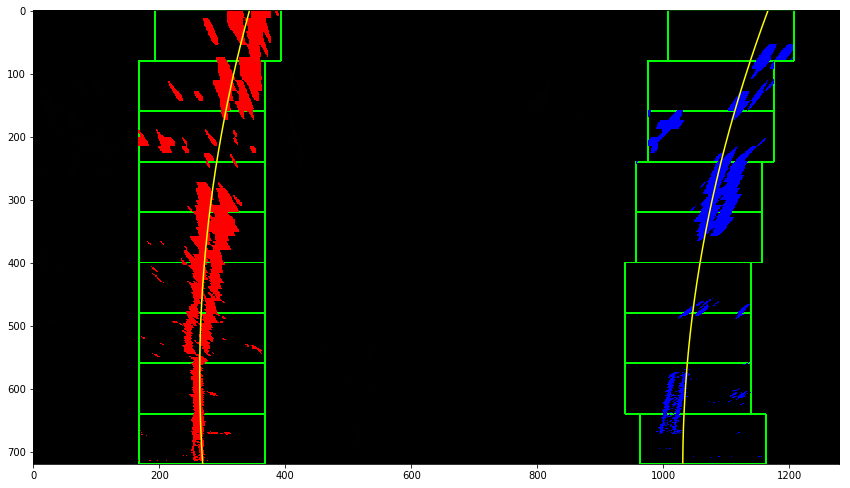

In [1790]:

def find_lane_pixels(binary_warped,leftx_base,rightx_base):
    histogram = np.sum(binary_warped, axis=0) #(349,1059)
    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 51

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # 
    global buff_left_xs, buff_right_xs
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
                
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###

        new_leftx_current = leftx_current
        new_rightx_current = rightx_current
        
        if len(good_left_inds) > minpix:
            new_leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

        if len(good_right_inds) > minpix:        
            new_rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        ### [NOTE} Apply moving avg. for denoising if x delta limit supasses            
        if (new_leftx_current != leftx_current) and np.abs(new_leftx_current-leftx_current) > 30 :
            leftx_current = leftx_current + np.int((new_leftx_current - leftx_current) * 0.5)

        if (new_rightx_current != rightx_current) and np.abs(new_rightx_current-rightx_current) > 30:
            rightx_current = rightx_current + np.int((new_rightx_current - rightx_current) * 0.5)
        ### [NOTE} Apply moving avg. for denoising if x delta limit supasses
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(ploty,leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fit, right_fit, left_fitx, right_fitx, ploty

# Find lane fixels throughout entire bird-eye-view
# Using bases found with only half bird-eye-view in y axis.
lx, ly, rx, ry, out_img = find_lane_pixels(birdeye_view,lx_base,rx_base)
ploty = np.linspace(0, birdeye_view.shape[0]-1, birdeye_view.shape[0])
l_fit, r_fit, l_fitx, r_fitx, ploty = fit_polynomial(ploty,lx, ly, rx, ry)

## Visualization ##
# Colors in the left and right lane regions
out_img[ly, lx] = [255, 0, 0]
out_img[ry, rx] = [0, 0, 255]
# Plot the result
f, ax1 = plt.subplots(1, 1, figsize=(12, 7))
f.tight_layout()
ax1.plot(l_fitx, ploty, color='yellow')
ax1.plot(r_fitx, ploty, color='yellow')
ax1.imshow(out_img)
ax1.set_title('', fontsize=40)
plt.savefig('../output_images/lane_identification.png')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

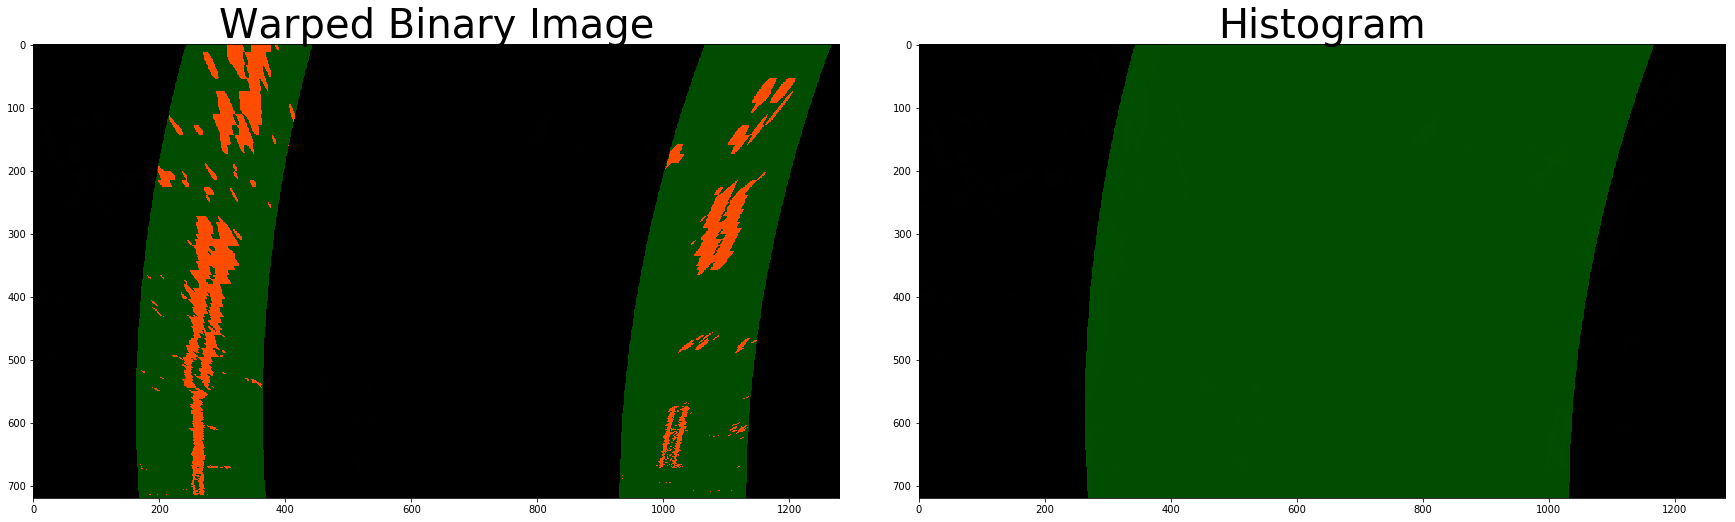

In [1781]:
def search_around_poly(binary_warped, left_fit, right_fit,left_fitx, right_fitx, ploty):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
                      
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    window_img = np.zeros_like(out_img)

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0)) #np.int_ is np.int32
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return out_img

def search_inbetween_poly(binary_warped, left_fit, right_fit,left_fitx, right_fitx, ploty):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    one_pts = np.hstack((left_line_pts, right_line_pts))
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    window_img = np.zeros_like(out_img)
    cv2.fillPoly(window_img, np.int_([one_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
out_img = search_around_poly(birdeye_view, l_fit,r_fit,l_fitx,r_fitx, ploty)
out_image_one_stripe = search_inbetween_poly(birdeye_view, l_fit, r_fit,l_fitx, r_fitx, ploty)

# Visualize the resulting histogram
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 7))
f.tight_layout()
ax1.imshow(out_img)
# ax1.imshow(warped[warped.shape[0]//2:,:])
ax1.set_title('Warped Binary Image', fontsize=40)
# ax2.imshow(result)
ax2.imshow(out_image_one_stripe)
ax2.set_title('Histogram', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 5. Determine the curvature of the lane and vehicle position with respect to center.

In [1782]:
#Calculates the curvature of polynomial functions in pixels.
def measure_curvature_pixels(left_fit, right_fit,ploty):
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    f_1prime = 2*left_fit[0]*y_eval + left_fit[1]
    f_2prime = 2*left_fit[0]
    left_curverad = ((1+f_1prime**2)**(1.5))/np.absolute(f_2prime)
    
    #y_eval = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    f_1prime = 2*right_fit[0]*y_eval + right_fit[1]
    f_2prime = 2*right_fit[0]
    right_curverad = ((1+f_1prime**2)**(1.5))/np.absolute(f_2prime)

    return left_curverad, right_curverad

# Calculate the radius of curvature in pixels for both lane lines
ploty = np.linspace(0, birdeye_gray_binary.shape[0]-1, birdeye_gray_binary.shape[0])
left_curverad, right_curverad = measure_curvature_pixels(l_fit, r_fit,ploty)
print(left_curverad, right_curverad)


2133.374702243293 1961.9814640834834


In [1783]:
# Calculates the curvature of polynomial functions in meters.
def measure_curvature_real(left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    ##### TO-DO: Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fitx = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fitx = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    #y_eval = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    f_1prime = 2*left_fitx[0]*y_eval + left_fitx[1]
    f_2prime = 2*left_fitx[0]
    left_curverad = ((1+f_1prime**2)**(1.5))/np.absolute(f_2prime)
    
    #y_eval = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    f_1prime = 2*right_fitx[0]*y_eval + right_fitx[1]
    f_2prime = 2*right_fitx[0]
    right_curverad = ((1+f_1prime**2)**(1.5))/np.absolute(f_2prime)  
    
    return left_curverad, right_curverad

# Calculate the radius of curvature in meters for both lane lines
m_left_curverad, m_right_curverad = measure_curvature_real(l_fitx, r_fitx, ploty)

print(m_left_curverad, 'm', m_right_curverad, 'm')
# r = 644/696
# m = (3.7 / 2)
# print(m - m * r)

696.1971362761963 m 644.39659923744 m


## 6. Warp the detected lane boundaries back onto the original image.

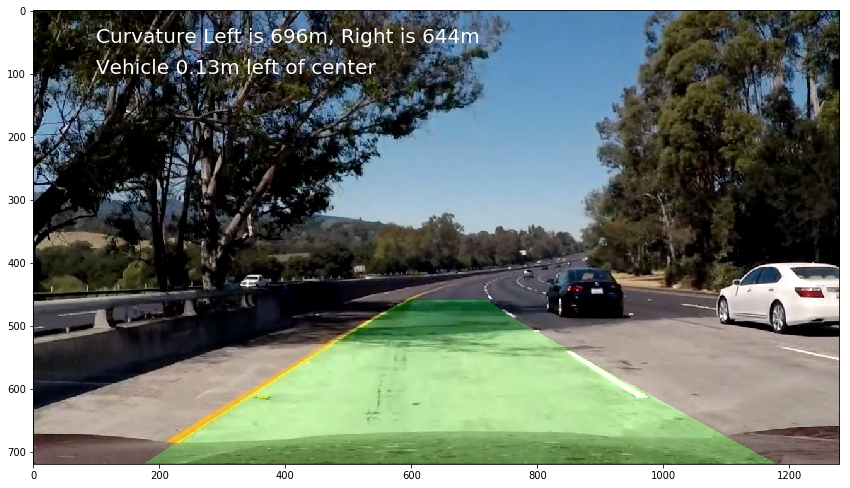

In [1802]:
# set 4 points for warping.
    # set 4 points for warping.
src = np.float32(
   [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

dst = np.float32(
   [[(img_size[0] / 4 - 30), 0],
    [(img_size[0] / 4 - 30), img_size[1]],
    [(img_size[0] * 3 / 4 + 30), img_size[1]],
    [(img_size[0] * 3 / 4 + 30), 0]])

M = cv2.getPerspectiveTransform(dst, src) #Transform function takes float32
unwarped4 = cv2.warpPerspective(out_image_one_stripe, M, img_size, flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(unwarped4, 0.8, image2, 1.0, 0.)

# Plot the result
f, ax1 = plt.subplots(1, 1, figsize=(12, 7))
f.tight_layout()
ax1.imshow(result)

ax1.text(100,50,"Curvature Left is 696m, Right is 644m",color='white',fontsize=20)
ax1.text(100,100,"Vehicle 0.13m left of center",color='white',fontsize=20)
# ax1.set_title('Combo binary', fontsize=40)
plt.savefig('../output_images/example_output.png')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1834]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# image5 = mpimg.imread('../test_images/test5.jpg')

# mpimg.imread read images in RGB. 
def process_image(img):
    
    combo_binary, gray_binary = create_binary_image(img)
    birdeye_view = get_birdeyeview(gray_binary)
    lx_base, rx_base = get_basex(birdeye_view)
    
    ### [NOTE} Apply moving avg. for lx_base and rx_base.###
    global cum_rb, cum_lb
    cum_lb.append(lx_base); cum_rb.append(rx_base)
    
    if len(cum_lb) >= 20:
        lx_base = np.sum(cum_lb[-N:]) // 20
        rx_base = np.sum(cum_rb[-N:]) // 20
    ### [NOTE} Apply moving avg. for lx_base and rx_base.###
    
    lx, ly, rx, ry, out_img = find_lane_pixels(birdeye_view,lx_base,rx_base)
    ploty = np.linspace(0, birdeye_view.shape[0]-1, birdeye_view.shape[0])
    l_fit, r_fit, l_fitx, r_fitx, ploty = fit_polynomial(ploty,lx, ly, rx, ry)

    out_img = search_around_poly(birdeye_view, l_fit,r_fit,l_fitx,r_fitx, ploty)
    out_image_one_stripe = search_inbetween_poly(birdeye_view, l_fit, r_fit,l_fitx, r_fitx, ploty)    
    
    # set 4 points for warping.
    src = np.float32(
       [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

    dst = np.float32(
       [[(img_size[0] / 4 - 30), 0],
        [(img_size[0] / 4 - 30), img_size[1]],
        [(img_size[0] * 3 / 4 + 30), img_size[1]],
        [(img_size[0] * 3 / 4 + 30), 0]])
    
    M = cv2.getPerspectiveTransform(dst, src) #Transform function takes float32
    unwarped_final = cv2.warpPerspective(out_image_one_stripe, M, img_size, flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(unwarped_final, 0.8, img, 1.0, 0.)
    
    return result

# out_image5 = process_image(image5)
# f, ax1 = plt.subplots(1, 1, figsize=(12, 7))
# f.tight_layout()
# ax1.imshow(out_image5)
# ax1.text(100,50,"Curvature Left is 696m, Right is 644m",color='white',fontsize=20)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [1789]:
challenge_output = '../output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)

clip3 = VideoFileClip('../project_video.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)










                                     







                                        




                                                                  











                            














                     
                                                               















                  

                                                            





                                              



                                                      

















        









                                  






                                           
















             


                                                         













                       










                               












                         








t:   1%|          | 7/1260 [32:16:05<01:46, 11.79it/s, now=None]







t:   1%|          | 7/1260 [32:16:22<01:47, 11.61it/s, now=None]




t:  49%|████

Moviepy - Building video ../output_images/project_video.mp4.
Moviepy - Writing video ../output_images/project_video.mp4






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...

















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















                

t:   1%|          | 7/1260 [32:18:31<01:52, 11.14it/s, now=None]
















t:   2%|▏         | 19/1260 [2:13:23<01:56, 10.62it/s, now=None]


t:  49%|████▊     | 613/1260 [45:23:46<02:03,  5.23it/s, now=None]













t:   2%|▏         | 25/1260 [31:43:04<01:55, 10.70it/s, now=None]










t:   1%|          | 7/1260 [32:15:27<01:55, 10.82it/s, now=None]












t:   1%|          | 7/1260 [32:13:04<01:53, 11.07it/s, now=None]

Moviepy - Done !
Moviepy - video ready ../output_images/project_video.mp4
CPU times: user 2min 17s, sys: 26.7 s, total: 2min 43s
Wall time: 1min 59s


In [1791]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

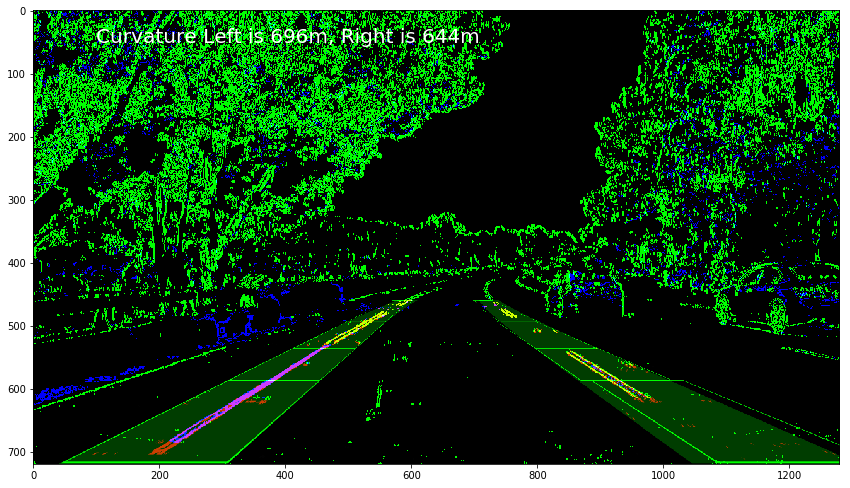

In [1794]:
cum_rb = []
cum_lb = []
image5 = mpimg.imread('../test_images/test5.jpg')

# mpimg.imread read images in RGB. 
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
      
    combo_binary, gray_binary = create_binary_image(img)
    birdeye_view = get_birdeyeview(gray_binary)
    lx_base, rx_base = get_basex(birdeye_view)

    # 1. Test applying moving avg. for lb and rb.
    # 2. Test limit. of distance bet. left_base and left_base is max.700 pixels(3.7m) min. 600 pixels
    global cum_rb, cum_lb
    cum_lb.append(lx_base); cum_rb.append(rx_base)
    
    if len(cum_lb) >= 20:
        lx_base = np.sum(cum_lb[-N:]) // 20
        rx_base = np.sum(cum_rb[-N:]) // 20
        
    lx, ly, rx, ry, out_img_boxes = find_lane_pixels(birdeye_view,lx_base,rx_base)
    ploty = np.linspace(0, birdeye_view.shape[0]-1, birdeye_view.shape[0])
    l_fit, r_fit, l_fitx, r_fitx, ploty = fit_polynomial(ploty,lx, ly, rx, ry)

    out_img_two_stripe = search_around_poly(birdeye_view, l_fit,r_fit,l_fitx,r_fitx, ploty)
    out_image_one_stripe = search_inbetween_poly(birdeye_view, l_fit, r_fit,l_fitx, r_fitx, ploty)    
#     left_curverad, right_curverad = measure_curvature_pixels(l_fit, r_fit,ploty)
#     m_left_curverad, m_right_curverad = measure_curvature_real(l_fitx, r_fitx, ploty)
    
    # set 4 points for warping.
    src = np.float32(
       [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

    dst = np.float32(
       [[(img_size[0] / 4 - 30), 0],
        [(img_size[0] / 4 - 30), img_size[1]],
        [(img_size[0] * 3 / 4 + 30), img_size[1]],
        [(img_size[0] * 3 / 4 + 30), 0]])
    
    M = cv2.getPerspectiveTransform(dst, src) #Transform function takes float32
    unwarped1 = cv2.warpPerspective(out_img_two_stripe, M, img_size, flags=cv2.INTER_LINEAR)
    unwarped2 = cv2.warpPerspective(out_img_boxes, M, img_size, flags=cv2.INTER_LINEAR)
    tmp = cv2.addWeighted(unwarped1, 0.8, combo_binary, 1.0, 0.)
    result = cv2.addWeighted(unwarped2, 0.8, tmp, 1.0, 0.)
    
    return result

out_image5 = process_image(image5)

f, ax1 = plt.subplots(1, 1, figsize=(12, 7))
f.tight_layout()
ax1.imshow(out_image5)
ax1.text(100,50,"Curvature Left is 696m, Right is 644m",color='white',fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [1777]:
challenge_output_extra = '../output_images/project_video_output_extra.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)

clip3 = VideoFileClip('../project_video.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output_extra, audio=False)










                                     







                                        




                                                                  











                            














                     
                                                               















                  

                                                            





                                              



                                                      

















        









                                  






                                           
















             


                                                         













                       










                               












                         








t:   1%|          | 7/1260 [32:05:21<01:46, 11.79it/s, now=None]







t:   1%|          | 7/1260 [32:05:38<01:47, 11.61it/s, now=None]




t:  49%|████

Moviepy - Building video ../output_images/project_video_output_extra.mp4.
Moviepy - Writing video ../output_images/project_video_output_extra.mp4






















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...

















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidden) ...


















 ... (more hidde

t:   1%|          | 8/1260 [36:18:07<01:48, 11.57it/s, now=None]



t:  49%|████▊     | 613/1260 [45:09:21<01:14,  8.66it/s, now=None]

















t:   1%|          | 13/1260 [12:57<02:02, 10.21it/s, now=None]









t:   1%|          | 7/1260 [32:06:54<01:49, 11.41it/s, now=None]






t:   1%|          | 7/1260 [32:07:53<01:52, 11.14it/s, now=None]
















t:   2%|▏         | 19/1260 [2:02:45<01:56, 10.62it/s, now=None]


t:  49%|████▊     | 613/1260 [45:13:08<02:03,  5.23it/s, now=None]













t:   2%|▏         | 25/1260 [31:32:26<01:55, 10.70it/s, now=None]










t:   1%|          | 7/1260 [32:04:49<01:55, 10.82it/s, now=None]












t:   1%|          | 7/1260 [32:02:26<01:53, 11.07it/s, now=None]








                                     







                                        




                                                                  











                            














                     
                  

Moviepy - Done !
Moviepy - video ready ../output_images/project_video_output_extra.mp4
CPU times: user 2min 38s, sys: 30 s, total: 3min 8s
Wall time: 2min 5s


In [1778]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output_extra))